# 11장 사전 학습 모델 활용하기

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [ ]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 공통 함수 불러오기

In [ ]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## 11.4 적응형 풀링 함수(nn.AdaptiveAvgPool2d 함수)

In [ ]:
# nn.AdaptiveAvgPool2d 정의
p = nn.AdaptiveAvgPool2d((1,1))
print(p)

# 선형 함수의 정의
l1 = nn.Linear(32, 10)
print(l1)

AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=32, out_features=10, bias=True)


In [ ]:
# 사전 학습 모델 시뮬레이션
inputs = torch.randn(100, 32, 16, 16)
m1 = p(inputs)
m2 = m1.view(m1.shape[0],-1)
m3 = l1(m2)

# shape 확인
print(m1.shape)
print(m2.shape)
print(m3.shape)

torch.Size([100, 32, 1, 1])
torch.Size([100, 32])
torch.Size([100, 10])


## 11.5 데이터 준비

In [ ]:
# 분류 클래스명 정의

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 분류 클래스 수는 10
n_output = len(classes)

In [ ]:
# Transforms 정의

# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.Resize(112),
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
  transforms.Resize(112),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [ ]:
# 데이터 취득용 함수 dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# 배치 사이즈 지정
batch_size = 50

# 데이터로더

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정함
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용은 셔플이 필요하지 않음
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False) 

## 11.6 ResNet18 불러오기

### 모델 불러오기

In [ ]:
#  라이브러리 임포트
from torchvision import models

# 사전 학습 모델 불러오기
# pretraind = True로 학습을 마친 파라미터를 동시에 불러오기
net = models.resnet18(pretrained = True)

### 모델 구조 확인

In [ ]:
# 모델 개요 표시 1

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델 개요 표시 2
net = net.to(device)
summary(net,(100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [ ]:
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


최종 레이어 함수의 변수명은 ``fc``임을 알 수 있다.

## 11.7 최종 레이어 함수 교체하기

In [ ]:
# 난수 고정
torch_seed()

# 최종 레이어 함수의 입력 차원수 확인
fc_in_features = net.fc.in_features

# 최종 레이어 함수 교체
net.fc = nn.Linear(fc_in_features, n_output)

In [ ]:
# 모델 개요 표시 1
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델 개요 표시 2

net = net.to(device)
summary(net,(100,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [100, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [100, 64, 112, 112]       128
├─ReLU: 1-3                              [100, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [100, 64, 56, 56]         --
├─Sequential: 1-5                        [100, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [100, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [100, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [100, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [100, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [100, 64, 56, 56]         --
│

In [ ]:
# 손실 계산 그래프 시각화

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

'resnet-18.png'

In [ ]:
# 모델 개요 표시 1
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델 개요 표시 2
net = net.to(device)
summary(net,(100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

## 11.8 학습과 결과 평가

### 초기 설정

In [ ]:
# 난수 고정
torch_seed()

# 사전 학습 모델 불러오기
# pretraind = True로 학습을 마친 파라미터도 함께 불러오기
net = models.resnet18(pretrained = True)

# 최종 레이어 함수 입력 차원수 확인
fc_in_features = net.fc.in_features

# 최종 레이어 함수 교체
net.fc = nn.Linear(fc_in_features, n_output)

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 파일 초기화
history = np.zeros((0, 5))

### 학습

In [ ]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.01205 acc: 0.79410 val_loss: 0.00515, val_acc: 0.90950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00642 acc: 0.88934 val_loss: 0.00418, val_acc: 0.92790


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00516 acc: 0.91160 val_loss: 0.00392, val_acc: 0.93400


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00438 acc: 0.92362 val_loss: 0.00357, val_acc: 0.93870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00383 acc: 0.93356 val_loss: 0.00340, val_acc: 0.94090


### 학습 결과 평가

초기상태 : 손실 : 0.00515  정확도 : 0.90950
최종상태 : 손실 : 0.00340 정확도 : 0.94090


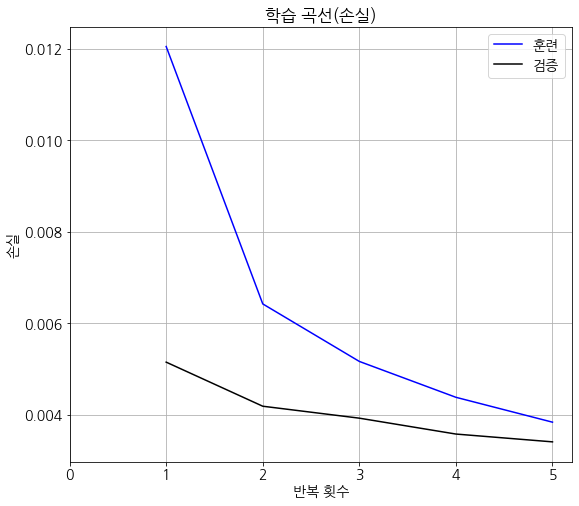

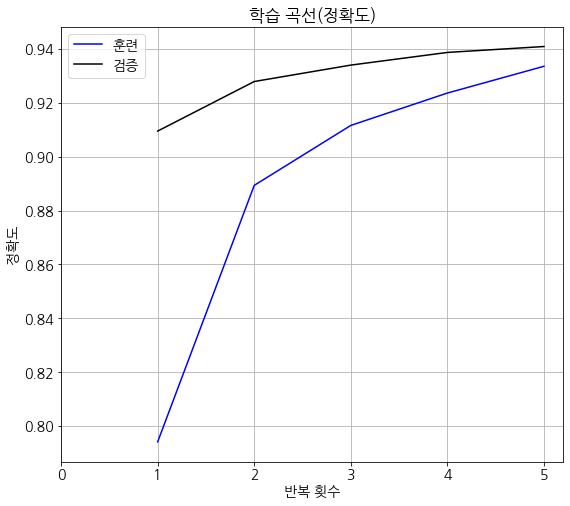

In [ ]:
# 결과 요약
evaluate_history(history)

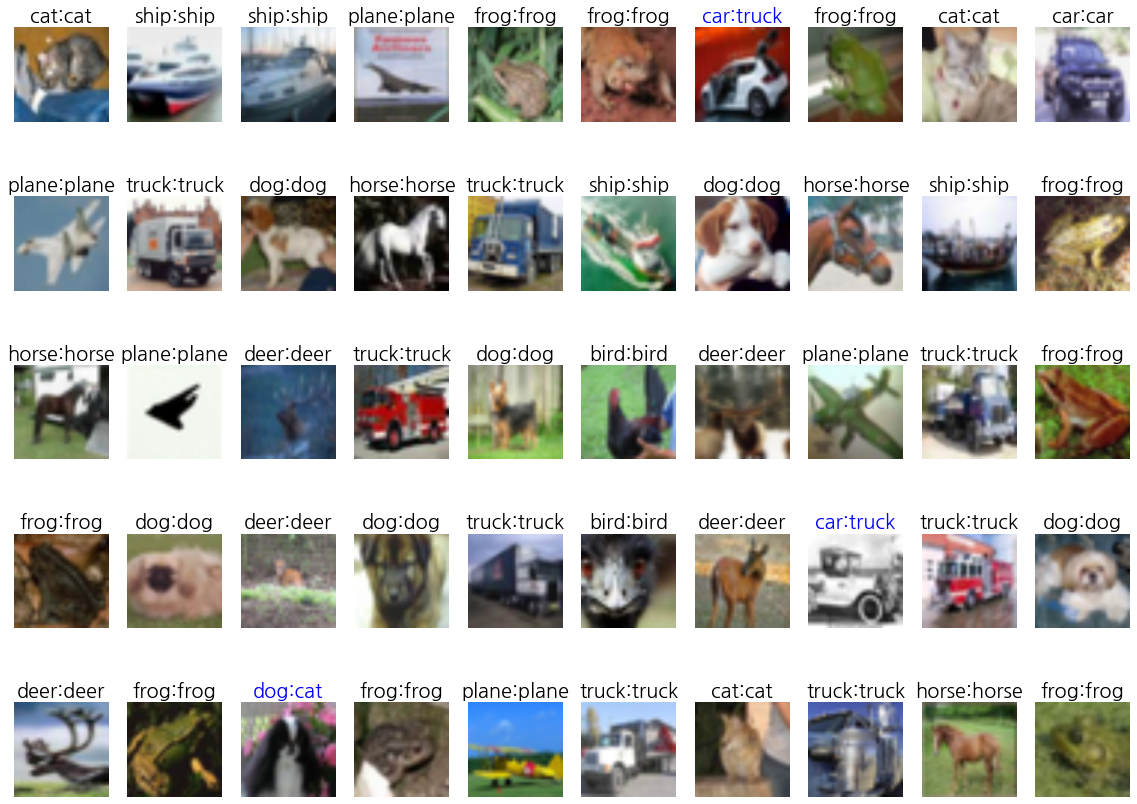

In [ ]:
# 이미지와 정답, 예측 결과를 함께 표시
show_images_labels(test_loader, classes, net, device)

## 11.9 VGG-19-BN 활용하기

### 모델 불러오기

In [ ]:
# 사전 학습 모델 불러오기
from torchvision import models
net = models.vgg19_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

### 모델 구조 확인

In [ ]:
# 모델 개요 표시 1
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

최종 레이어 함수는``classifier[6]``임을 알 수 있다.

In [ ]:
# 최종 레이어 함수 확인
print(net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


### 최종 레이어 함수 교체

In [ ]:
# 난수 고정
torch_seed()

# 최종 레이어 함수 교체
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

# features 마지막의 MaxPool2d 제거
net.features = net.features[:-1]

# AdaptiveAvgPool2d 제거
net.avgpool = nn.Identity()

In [ ]:
# 모델 개요 표시 2
net = net.to(device)
summary(net,(100,3,112,112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 112, 112]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 112, 112]       128
│    └─ReLU: 2-3                         [100, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [100, 64, 112, 112]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 112, 112]       128
│    └─ReLU: 2-6                         [100, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                    [100, 64, 56, 56]         --
│    └─Conv2d: 2-8                       [100, 128, 56, 56]        73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 56, 56]        256
│    └─ReLU: 2-10                        [100, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [100, 128, 56, 56]        147,

In [ ]:
# 손실 계산 그래프 시각화

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

'vgg-19-bn.png'

### 초기 설정

In [ ]:
# 난수 고정
torch_seed()

# 사전 학습 모델 불러오기
net = models.vgg19_bn(pretrained = True)

# 최종 레이어 함수 교체
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

# features 마지막의 MaxPool2d 제거
net.features = net.features[:-1]

# AdaptiveAvgPool2d 제거
net.avgpool = nn.Identity()

# 모델을 GPU로 전송
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 초기화
history = np.zeros((0, 5))


### 학습

In [ ]:
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.00997 acc: 0.83144 val_loss: 0.00380, val_acc: 0.93670


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00490 acc: 0.91698 val_loss: 0.00308, val_acc: 0.94760


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00372 acc: 0.93686 val_loss: 0.00271, val_acc: 0.95330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00310 acc: 0.94764 val_loss: 0.00266, val_acc: 0.95550


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00274 acc: 0.95464 val_loss: 0.00250, val_acc: 0.95760


### 결과 확인

초기상태 : 손실 : 0.00380  정확도 : 0.93670
최종상태 : 손실 : 0.00250 정확도 : 0.95760


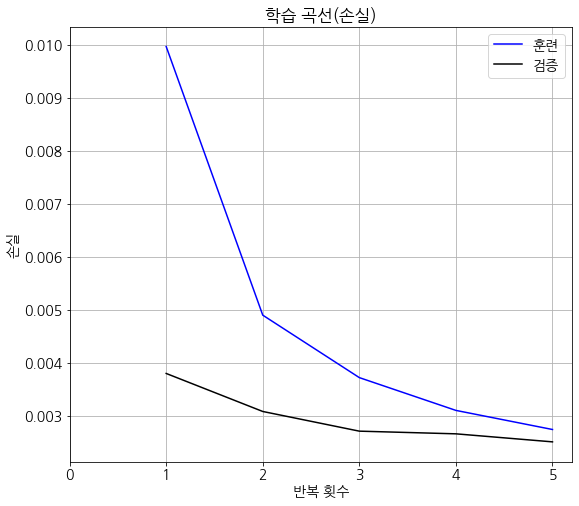

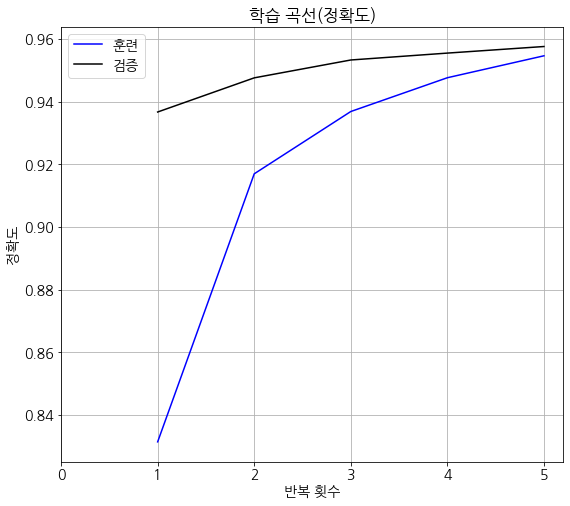

In [ ]:
# 결과 요약
evaluate_history(history)

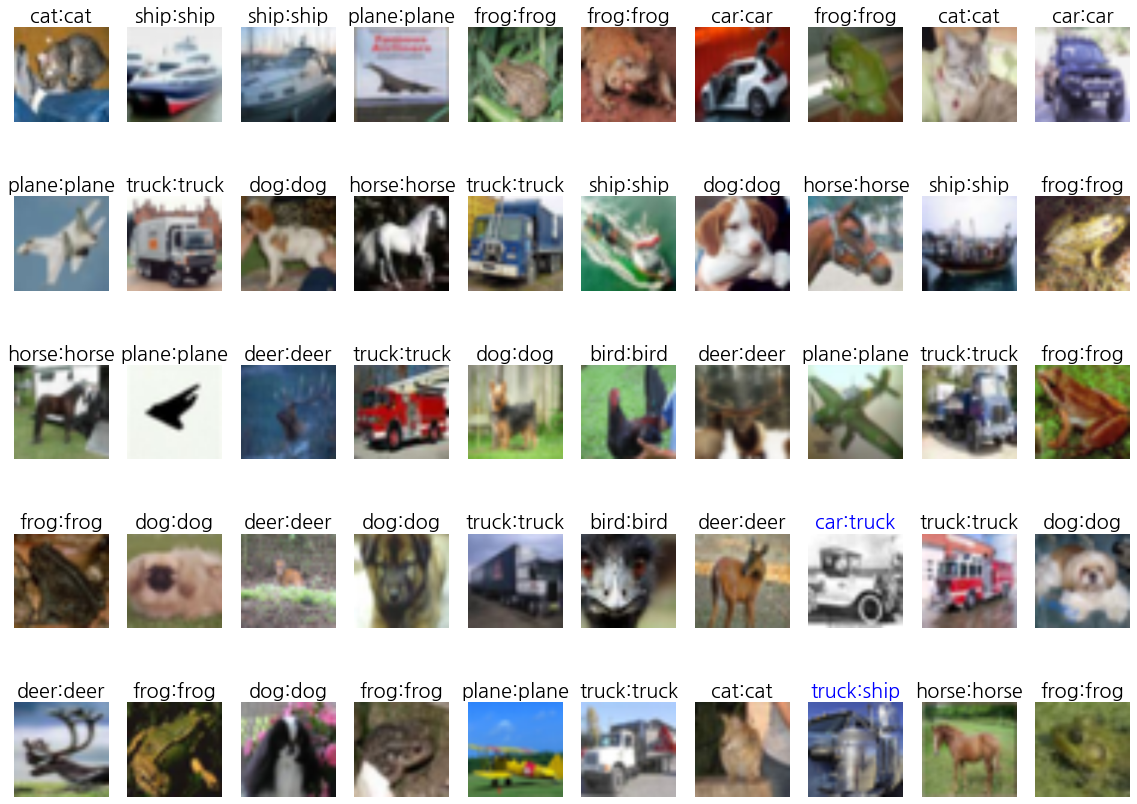

In [ ]:
# 이미지와 정답, 예측 결과를 함께 표시
show_images_labels(test_loader, classes, net, device)

## 칼럼 CIFAR-10에 전이 학습을 적용한 경우

In [ ]:
# 전이 학습

# 사전 학습 모델 불러오기
net = models.resnet18(pretrained = True)

# 모든 파라미터의 경사 계산을 OFF로 설정
for param in net.parameters():
    param.requires_grad = False

# 난수 고정
torch_seed()

# 최종 레이어 함수 교체
net.fc = nn.Linear(net.fc.in_features, n_output)

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 파라미터 변경은 최종 레이어 함수로 한정
optimizer = optim.SGD(net.fc.parameters(), lr=lr, momentum=0.9)

# history 파일 초기화
history = np.zeros((0, 5))

NameError: ignored

In [ ]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# 결과 요약
evaluate_history(history)

## 칼럼 범용적인 사전 학습 모델을 작성하는 법

### 모델 불러오기

In [ ]:
# 사전 학습 모델 불러오기
from torchvision import models

net = models.vgg19_bn(pretrained = True)

### 모델 개요 표시 1

In [ ]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### 중간 텐서 확인

In [ ]:
# 원본 데이터 사이즈의 경우(배치사이즈 100)
net = net.to(device)
summary(net, (100, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 224, 224]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 224, 224]       128
│    └─ReLU: 2-3                         [100, 64, 224, 224]       --
│    └─Conv2d: 2-4                       [100, 64, 224, 224]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 224, 224]       128
│    └─ReLU: 2-6                         [100, 64, 224, 224]       --
│    └─MaxPool2d: 2-7                    [100, 64, 112, 112]       --
│    └─Conv2d: 2-8                       [100, 128, 112, 112]      73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 112, 112]      256
│    └─ReLU: 2-10                        [100, 128, 112, 112]      --
│    └─Conv2d: 2-11                      [100, 128, 112, 112]      147,

In [ ]:
# 실습용 데이터 사이즈의 경우(배치사이즈 100)
summary(net, (100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [100, 512, 3, 3]          --
│    └─Conv2d: 2-1                       [100, 64, 112, 112]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 112, 112]       128
│    └─ReLU: 2-3                         [100, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [100, 64, 112, 112]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 112, 112]       128
│    └─ReLU: 2-6                         [100, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                    [100, 64, 56, 56]         --
│    └─Conv2d: 2-8                       [100, 128, 56, 56]        73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 56, 56]        256
│    └─ReLU: 2-10                        [100, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [100, 128, 56, 56]        147,

### 레이어 함수 교체하기

In [ ]:
# 난수 고정
torch_seed()

# 최종 레이어 함수 교체
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

In [ ]:
# features의 마지막 요소(MaxPool2d)를 제거
net.features = net.features[:-1]
print(net.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
# avgpool에 위치한AdaptiveAvgPool2d을 아무것도 하지 않는 함수(nn.Identity)로 치환
net.avgpool = nn.Identity()

### 결과 확인

In [ ]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# 실습용 데이터 사이즈로 중간 텐서 확인(배치사이즈 100)
net = net.to(device)
summary(net,(100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 112, 112]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 112, 112]       128
│    └─ReLU: 2-3                         [100, 64, 112, 112]       --
│    └─Conv2d: 2-4                       [100, 64, 112, 112]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 112, 112]       128
│    └─ReLU: 2-6                         [100, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                    [100, 64, 56, 56]         --
│    └─Conv2d: 2-8                       [100, 128, 56, 56]        73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 56, 56]        256
│    └─ReLU: 2-10                        [100, 128, 56, 56]        --
│    └─Conv2d: 2-11                      [100, 128, 56, 56]        147,